# MM_lab1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Opening a dataset with pandas 

In [2]:
df = pd.read_csv (r'C:\\Users\\Rock4\\Downloads\\saveecobot_23976.csv')

In [3]:
df.head()

,device_id,phenomenon,value,logged_at,value_text
0,23976,pm10,10.20,2023-07-31 12:18:03,NaN
1,23976,pm25,9.30,2023-07-31 12:18:03,NaN
2,23976,heca_temperature,26.32,2023-07-31 12:18:03,NaN
3,23976,heca_humidity,58.82,2023-07-31 12:18:03,NaN
4,23976,temperature,23.63,2023-07-31 12:18:03,NaN


У моєму випадку дані взяті за адресою бульвар Чоколівський, 33 у місті Київ

## Check for missing values and NaN.

In [4]:
df.isnull().values.any()

True

In [5]:
df.isnull().sum()

device_id          0
phenomenon         0
value              0
logged_at          0
value_text    676596
dtype: int64

## Data cleaning

In [6]:
data_cleaned = df.drop(columns=['value_text'])
data_cleaned.head()

,device_id,phenomenon,value,logged_at
0,23976,pm10,10.20,2023-07-31 12:18:03
1,23976,pm25,9.30,2023-07-31 12:18:03
2,23976,heca_temperature,26.32,2023-07-31 12:18:03
3,23976,heca_humidity,58.82,2023-07-31 12:18:03
4,23976,temperature,23.63,2023-07-31 12:18:03


In [7]:
data_cleaned.isnull().values.any() 

False

## Dataset rotation

In [8]:
pivoted_data = data_cleaned.pivot_table(
    index=['device_id', 'logged_at'],
    columns='phenomenon',
    values='value', 
    aggfunc='first'
)

pivoted_data.reset_index(inplace=True)

In [9]:
pivoted_data.head()

phenomenon,device_id,logged_at,heca_humidity,heca_temperature,humidity,max_micro,min_micro,pm10,pm25,pressure_pa,signal,temperature
0,23976,2023-07-31 12:18:03,58.82,26.32,100.0,22410.0,1269.0,10.2,9.3,989653.8,-89.0,23.63
1,23976,2023-07-31 12:20:30,61.77,25.61,100.0,22622.0,1262.0,11.2,10.1,989644.4,-86.0,23.68
2,23976,2023-07-31 12:23:00,62.61,25.88,100.0,22553.0,1274.0,10.6,9.7,989682.0,-85.0,23.72
3,23976,2023-07-31 12:25:27,59.13,26.90,100.0,22701.0,1257.0,10.5,9.5,989661.3,-85.0,23.72
4,23976,2023-07-31 12:28:10,58.41,26.76,100.0,23630.0,1254.0,12.4,11.1,989660.1,-86.0,23.72


In [10]:
pivoted_data.isnull().values.any() 

True

In [11]:
pivoted_data.isnull().sum()

phenomenon
device_id             0
logged_at             0
heca_humidity       110
heca_temperature    110
humidity            110
max_micro             0
min_micro             0
pm10                952
pm25                952
pressure_pa         110
signal                0
temperature         110
dtype: int64

In [12]:
cleaned_data = pivoted_data.dropna(subset=['pm10', 'pm25'])

In [13]:
columns_to_fill = ['heca_humidity', 'heca_temperature', 'humidity', 'pressure_pa', 'temperature']

for column in columns_to_fill:
    cleaned_data.loc[:, column] = cleaned_data[column].fillna(cleaned_data[column].mean())

In [14]:
print(cleaned_data.isnull().sum())

phenomenon
device_id           0
logged_at           0
heca_humidity       0
heca_temperature    0
humidity            0
max_micro           0
min_micro           0
pm10                0
pm25                0
pressure_pa         0
signal              0
temperature         0
dtype: int64


## Correlation analysis

pm10                0.897856
humidity            0.311344
heca_humidity       0.310462
min_micro           0.068070
max_micro           0.028597
pressure_pa         0.005393
signal             -0.044782
heca_temperature   -0.251432
temperature        -0.303331
dtype: float64


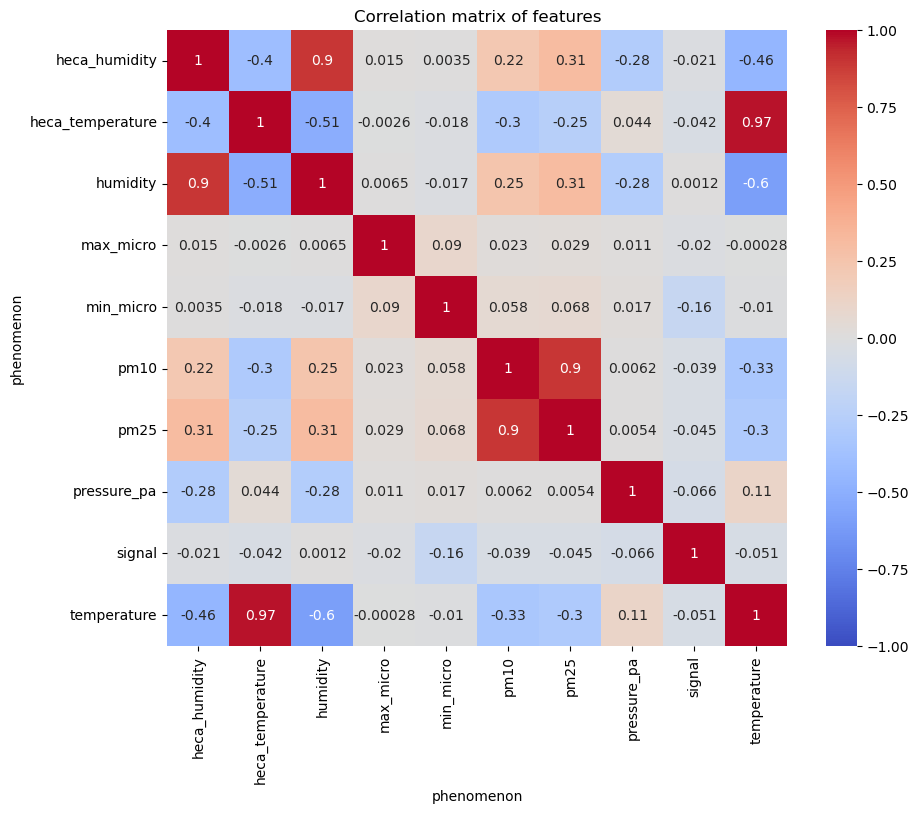

In [15]:
corr_data = cleaned_data.drop(columns=['device_id', 'logged_at'])

def pearson_correlation(X, Y):
    mean_X, mean_Y = np.mean(X), np.mean(Y)
    num = np.sum((X - mean_X) * (Y - mean_Y))
    den = np.sqrt(np.sum((X - mean_X) ** 2) * np.sum((Y - mean_Y) ** 2))
    return num / den

correlation_results = {}
for column in corr_data.columns:
    if column != 'pm25':
        correlation_results[column] = pearson_correlation(corr_data[column], corr_data['pm25'])

correlation_series = pd.Series(correlation_results).sort_values(ascending=False)
print(correlation_series)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of features')
plt.show()

 - PM2,5 та PM10 мають сильний зв'язок (кореляція 0,897).
 - Інші характеристики мають помірний зв'язок з PM2.5 (близько 0,31).
 - Температура негативно пов'язана з PM2,5.

In [16]:
top_3_features = correlation_series.head(3).index.tolist()
print(f"Three features with the highest correlation: {top_3_features}") 

Three features with the highest correlation: ['pm10', 'humidity', 'heca_humidity']


## Regression analysis

In [17]:
X = corr_data[top_3_features].values
y = corr_data['pm25'].values
X_b = np.c_[np.ones((X.shape[0], 1)), X]

train_size = int(0.8 * len(X_b))
X_train, X_test = X_b[:train_size], X_b[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

def linear_regression(X, y):
    beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return beta

beta = linear_regression(X_train, y_train)
print(f"Regression coefficients: {beta}")

Regression coefficients: [-2.02380801  0.48149289 -0.00962133  0.06921248]


- PM10 має найбільший вплив на PM2,5 (коефіцієнт 0,481), що підтверджує сильний зв'язок. 
- Вологість має мінімальний вплив, тоді як додаткова вологість демонструє слабкий позитивний ефект.

## Calculation MSE and R²

Mean Squared Error (MSE): 1.980480764146588
R-squared: 0.6607668452453921


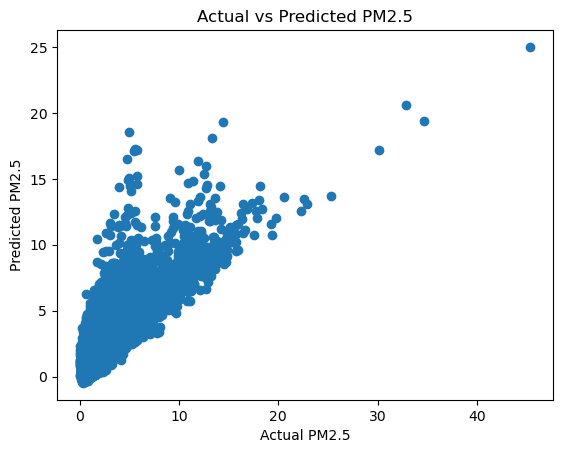

In [18]:
y_pred = X_test.dot(beta)

mse = np.mean((y_pred - y_test) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

sst = np.sum((y_test - np.mean(y_test)) ** 2) 
ssr = np.sum((y_pred - y_test) ** 2)
r_squared = 1 - (ssr / sst)
print(f"R-squared: {r_squared}")

plt.scatter(y_test, y_pred)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.show()

- Модель має середньоквадратичне відхилення (MSE) 1,98, що є помірним показником. 
- Значення R² (0,66) показує, що модель пояснює близько 66% варіації даних, що є добрим, але не ідеальним. 

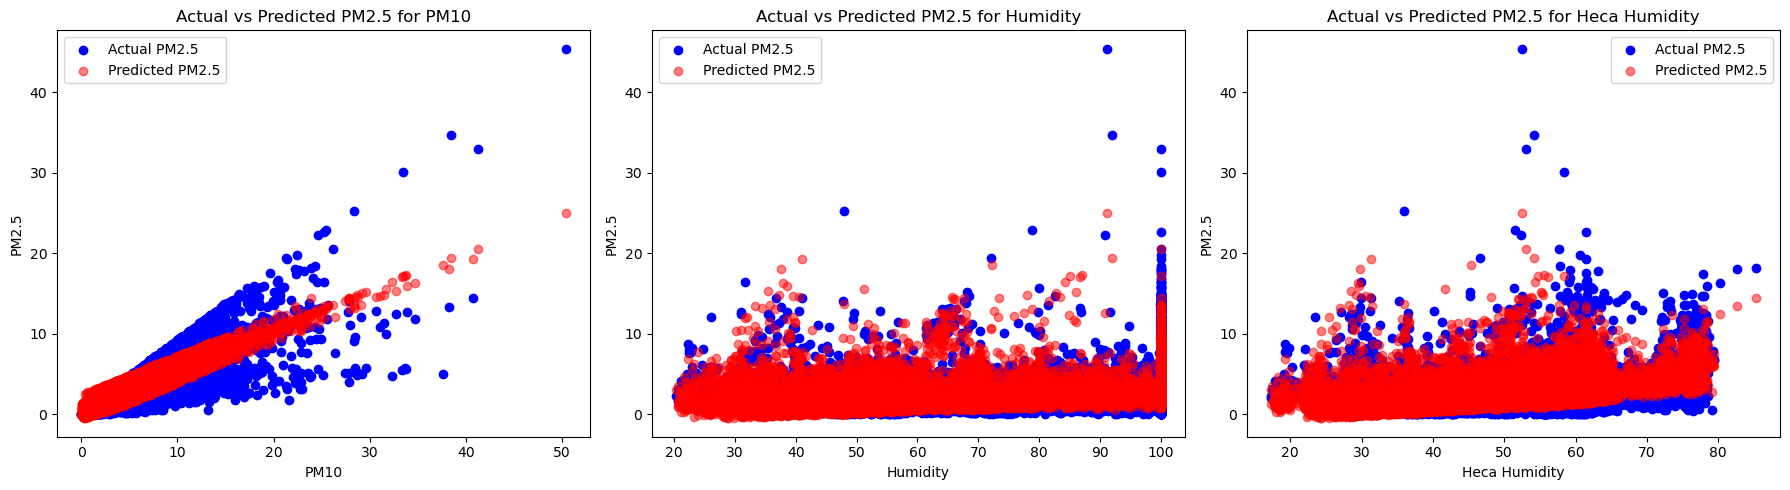

In [19]:
plt.figure(figsize=(18, 5))

# PM10
plt.subplot(1, 3, 1)
plt.scatter(X_test[:, 1], y_test, color='blue', label='Actual PM2.5')
plt.scatter(X_test[:, 1], y_pred, color='red', label='Predicted PM2.5', alpha=0.5)
plt.xlabel('PM10')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 for PM10')
plt.legend()

# Humidity
plt.subplot(1, 3, 2)
plt.scatter(X_test[:, 2], y_test, color='blue', label='Actual PM2.5')
plt.scatter(X_test[:, 2], y_pred, color='red', label='Predicted PM2.5', alpha=0.5)
plt.xlabel('Humidity')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 for Humidity')
plt.legend()

# Heca Humidity
plt.subplot(1, 3, 3)
plt.scatter(X_test[:, 3], y_test, color='blue', label='Actual PM2.5')  
plt.scatter(X_test[:, 3], y_pred, color='red', label='Predicted PM2.5', alpha=0.5)
plt.xlabel('Heca Humidity')
plt.ylabel('PM2.5')
plt.title('Actual vs Predicted PM2.5 for Heca Humidity')
plt.legend()

plt.tight_layout()
plt.show()

## PM2.5 analysis by time of day

time_of_day
Night        4.911861
Morning      4.873014
Afternoon    3.640341
Evening      5.115568
Name: pm25, dtype: float64


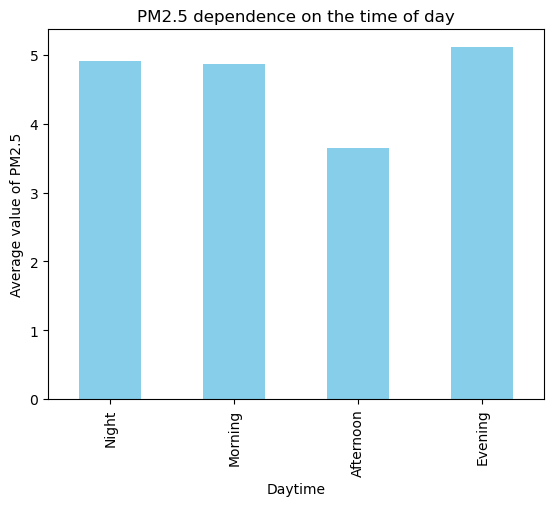

In [21]:
cleaned_data.loc[:, 'time_of_day'] = pd.to_datetime(cleaned_data['logged_at']).dt.hour
bins = [0, 6, 12, 18, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening']
cleaned_data.loc[:, 'time_of_day'] = pd.cut(cleaned_data['time_of_day'], bins=bins, labels=labels, right=False)

mean_pm25_by_time = cleaned_data.groupby('time_of_day')['pm25'].mean()
print(mean_pm25_by_time)

mean_pm25_by_time.plot(kind='bar', color='skyblue')
plt.title('PM2.5 dependence on the time of day')
plt.xlabel('Daytime')
plt.ylabel('Average value of PM2.5')
plt.show()

- Рівень PM2.5 найвищий ввечері і найнижчий в середині дня. 
- Це може означати, що вдень повітря чистіше, але нам потрібно це перевірити, оскільки різниця невелика.